# 스팸 메일 분류하기

- 캐글에서 제공하는 스팸메일 데이터 https://www.kaggle.com/uciml/sms-spam-collection-dataset

# 1.데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('data/spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
# Null 값을 가진 샘플이 있는지 확인
df.isnull().values.any()

False

In [8]:
# 데이터 중복이 있는지 확인
df['v2'].nunique()

5169

In [9]:
# 데이터 중복 제거
df = df.drop_duplicates('v2', keep='first')

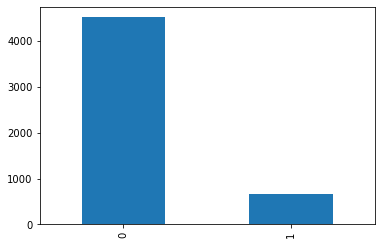

In [10]:
df['v1'].value_counts().plot(kind='bar')

In [11]:
df.groupby('v1').size()

v1
0    4516
1     653
dtype: int64

In [13]:
x_data = df['v2'].values
y_data = df['v1'].values
print('메일 본물의 개수:', len(x_data))
print('레이블의 개수:', len(y_data))

메일 본물의 개수: 5169
레이블의 개수: 5169


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(x_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [18]:
print(sequences[:3])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015]]


In [20]:
# 단어에 대한 인덱스
word_to_index = tokenizer.word_index
#print(word_to_index)

# 전체 단어 집합에서 회소 단어의 비율

In [22]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


In [23]:
vocab_size = len(word_to_index)+1
vocab_size

8921

메일의 최대 길이 : 189
메일의 평균 길이 : 15


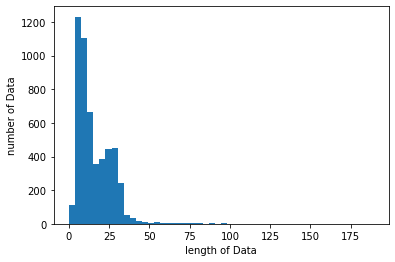

In [30]:
x_data = sequences
max_len = max(len(l) for l in x_data)
print('메일의 최대 길이 : %d'% max_len)
print('메일의 평균 길이 : %d'% (sum(map(len, x_data))/len(x_data)))

plt.hist([len(s) for s in x_data], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [31]:
# 전체 데이터셋의 길이를 max_len(189)에 맞춤
data = pad_sequences(x_data, maxlen=max_len)
data.shape

(5169, 189)

In [32]:
# 테스트용 데이터 20% 분리
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(data, y_data, test_size=.2, random_state=2020)

In [34]:
x_train.shape, x_test.shape

((4135, 189), (1034, 189))

# 2. 모델 설계 및 학습

In [35]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          285472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [39]:
# 훈련용 데이터 중에서 20%는 검증 데이터로 사용
history = model.fit(x_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Train on 3308 samples, validate on 827 samples
Epoch 1/10
3308/3308 [==============================] - 3s 808us/sample - loss: 0.4862 - accuracy: 0.7712 - val_loss: 0.3168 - val_accuracy: 0.8948
Epoch 2/10
3308/3308 [==============================] - 2s 503us/sample - loss: 0.1704 - accuracy: 0.9634 - val_loss: 0.2638 - val_accuracy: 0.8960
Epoch 3/10
3308/3308 [==============================] - 2s 495us/sample - loss: 0.0744 - accuracy: 0.9822 - val_loss: 0.0780 - val_accuracy: 0.9770
Epoch 4/10
3308/3308 [==============================] - 2s 491us/sample - loss: 0.0542 - accuracy: 0.9840 - val_loss: 0.0637 - val_accuracy: 0.9855
Epoch 5/10
3308/3308 [==============================] - 2s 489us/sample - loss: 0.0315 - accuracy: 0.9924 - val_loss: 0.0568 - val_accuracy: 0.9855
Epoch 6/10
3308/3308 [==============================] - 2s 488us/sample - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0624 - val_accuracy: 0.9831
Epoch 7/10
3308/3308 [==============================] - 2s 491us/

In [40]:
print('\n 테스트 정확도: %.4f'%(model.evaluate(x_test, y_test, verbose=2)[1]))

1034/1034 - 0s - loss: 0.0660 - accuracy: 0.9768

 테스트 정확도: 0.9768


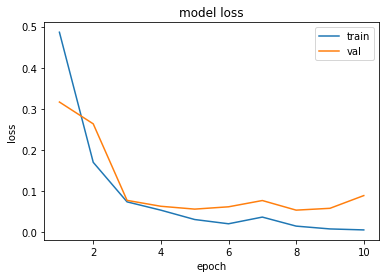

In [42]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()